PART B: DEEP LEARNING VIDEO CLASSIFICATION (REAL DATA)

This script implements:
1. 2D CNN (ResNet-18) + Temporal Pooling
2. 3D CNN (R(2+1)D-18)

Dataset:
- UCF-style directory
- Predefined train/test splits

Evaluation:
- Accuracy
- Precision (macro)
- Recall (macro)
- F1-score (macro)
- Confusion Matrix
- Training time
- Inference time per video

Author: 2024ab05275

In [2]:
pip install -r requirements.txt

INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 45.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ==========================================================
# IMPORTS
# ==========================================================
import os
import cv2
import time
import torch
import numpy as np
from pathlib import Path
from typing import List, Tuple
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# ==========================================================
# CONFIGURATION
# ==========================================================
# Current file is inside /code
CODE_DIR = Path.cwd()

# Project root is one level above
PROJECT_ROOT = CODE_DIR.parent

DATASET_ROOT = PROJECT_ROOT / "dataset"
SPLITS_DIR = DATASET_ROOT / "splits"

LOCAL_WEIGHTS = os.path.join(PROJECT_ROOT, "model", "resnet18-f37072fd.pth")

# Safety checks (VERY IMPORTANT)
assert DATASET_ROOT.exists(), f"Dataset not found at {DATASET_ROOT}"
assert SPLITS_DIR.exists(), f"Splits folder not found at {SPLITS_DIR}"
print("----------------------------------------------------------")
print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Dataset root: {DATASET_ROOT}")
print("----------------------------------------------------------")
NUM_FRAMES = 16                 # Frames sampled per video
IMG_SIZE = (224, 224)           # Required for pretrained CNNs
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Running on device: {DEVICE}")
print("----------------------------------------------------------\n")

----------------------------------------------------------
✅ Project root: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification
✅ Dataset root: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset
----------------------------------------------------------
🚀 Running on device: cuda
----------------------------------------------------------



In [21]:
# ==========================================================
# CLASS MAPPING (Derived from dataset folder names)
# ==========================================================
# This section automatically discovers class labels from the
# dataset directory structure.
#
# Expected directory format:
# DATASET_ROOT/
# ├── class_0/
# ├── class_1/
# ├── class_2/
# └── ...
#
# Each "class_*" folder represents one target class.
# ==========================================================

print("* Scanning dataset root for class folders.....")
print(f"* Dataset root path: {DATASET_ROOT}")
print("----------------------------------------------------------")
# ----------------------------------------------------------
# Step 1: Discover class directory names
# ----------------------------------------------------------
# - Iterate over all items inside DATASET_ROOT
# - Keep only directories
# - Keep only directory names that start with "class_"
# - Sort them to ensure consistent class index assignment
# ----------------------------------------------------------
CLASS_NAMES = sorted([
    d.name                      # Folder name (e.g., "class_1")
    for d in DATASET_ROOT.iterdir()
    if d.is_dir()                # Ensure it is a directory
    and d.name.startswith("class_")  # Enforce naming convention
])

print(f"* No of Class Folders Found : {len(CLASS_NAMES)}")
print("* Detected class folders (sorted):")
for cls in CLASS_NAMES:
    print(f"  - {cls}")
print("----------------------------------------------------------")

# ----------------------------------------------------------
# Step 2: Create class-to-index mapping
# ----------------------------------------------------------
# Assign a unique integer label to each class name.
# The index order is determined by the sorted CLASS_NAMES list.
#
# Example:
#   class_0 -> 0
#   class_1 -> 1
# ----------------------------------------------------------
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}

# ----------------------------------------------------------
# Step 3: Count total number of classes
# ----------------------------------------------------------
NUM_CLASSES = len(CLASS_NAMES)

# ----------------------------------------------------------
# Step 4: Log final class mapping
# ----------------------------------------------------------
print("* Final class-to-index mapping:")
for class_name, class_idx in CLASS_TO_IDX.items():
    print(f"  - {class_name} → {class_idx}")

print("----------------------------------------------------------")
print(f"* Total number of classes: {NUM_CLASSES}\n")

* Scanning dataset root for class folders.....
* Dataset root path: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset
----------------------------------------------------------
* No of Class Folders Found : 3
* Detected class folders (sorted):
  - class_1_Basketball
  - class_2_Biking
  - class_3_WalkingWithDog
----------------------------------------------------------
* Final class-to-index mapping:
  - class_1_Basketball → 0
  - class_2_Biking → 1
  - class_3_WalkingWithDog → 2
----------------------------------------------------------
* Total number of classes: 3



In [22]:
# ==========================================================
# VIDEO PREPROCESSING
# ==========================================================
"""
- OpenCV used for video loading
- Uniform frame sampling
- Resize to 224×224
- ImageNet normalization (mandatory for pretrained models)
"""

# ==========================================================
# IMAGENET PREPROCESSING TRANSFORM
# ==========================================================
# This transform prepares raw RGB image frames so they are
# compatible with ImageNet-pretrained CNN backbones
# (e.g., ResNet, EfficientNet).
#
# Expected input:
#   - NumPy array or PIL Image
#   - Shape: (H, W, C)
#   - Value range: [0, 255]
#
# Output:
#   - torch.Tensor
#   - Shape: (C, H, W)
#   - Normalized using ImageNet statistics
# ==========================================================

print("\n🎨 Initializing ImageNet preprocessing pipeline...")

# ----------------------------------------------------------
# Step 1: Convert image to PyTorch tensor
# ----------------------------------------------------------
# - Converts (H, W, C) → (C, H, W)
# - Scales pixel values from [0, 255] → [0.0, 1.0]
# ----------------------------------------------------------
print("🔄 Adding ToTensor():")
print("   - Converts NumPy/PIL image to torch.Tensor")
print("   - Reorders dimensions to (C, H, W)")
print("   - Scales pixel range to [0.0, 1.0]")

to_tensor_transform = transforms.ToTensor()

# ----------------------------------------------------------
# Step 2: Normalize using ImageNet statistics
# ----------------------------------------------------------
# Normalization ensures that input distribution matches
# what ImageNet-pretrained models were trained on.
#
# Channel order: RGB
#
# Formula per channel:
#   normalized = (x - mean) / std
# ----------------------------------------------------------
print("📏 Adding Normalize():")
print("   - Mean (RGB): [0.485, 0.456, 0.406]")
print("   - Std  (RGB): [0.229, 0.224, 0.225]")

normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# ----------------------------------------------------------
# Step 3: Compose transforms into a single pipeline
# ----------------------------------------------------------
print("🧩 Composing preprocessing transforms")

imagenet_transform = transforms.Compose([
    to_tensor_transform,
    normalize_transform
])

print("✅ ImageNet transform pipeline ready")


def load_video(video_path, num_frames=NUM_FRAMES):
    """
    Load a video file, extract frames, apply spatial preprocessing,
    perform uniform temporal sampling, and return a tensor suitable
    for deep learning models.

    Args:
        video_path (Path or str): Path to the video file.
        num_frames (int): Number of frames to sample uniformly.

    Returns:
        torch.Tensor: Video tensor of shape (T, C, H, W)
    """

    print("\n🎬 ==================================================")
    print("🎥 Loading video")
    print(f"📁 Video path      : {video_path}")
    print(f"🧮 Target #frames  : {num_frames}")
    print("🎬 ==================================================")

    # --------------------------------------------------
    # Step 1: Open video using OpenCV
    # --------------------------------------------------
    cap = cv2.VideoCapture(str(video_path))

    # Sanity check: ensure video file opened correctly
    if not cap.isOpened():
        raise RuntimeError(f"❌ Failed to open video file: {video_path}")

    frames = []
    frame_idx = 0

    # --------------------------------------------------
    # Step 2: Read video frame-by-frame
    # --------------------------------------------------
    while True:
        ret, frame = cap.read()

        # ret == False indicates end of video or read failure
        if not ret:
            print("⏹️  End of video reached or frame read failed")
            break

        # Convert color space from OpenCV default (BGR) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Resize frame to match model input size
        frame = cv2.resize(frame, IMG_SIZE)

        frames.append(frame)
        frame_idx += 1

        # Periodic logging for long videos
        if frame_idx % 25 == 0:
            print(f"  📸 Frames read so far: {frame_idx}")

    # --------------------------------------------------
    # Step 3: Release video capture resource
    # --------------------------------------------------
    cap.release()
    print(f"✅ Total frames extracted: {len(frames)}")

    # --------------------------------------------------
    # Step 4: Uniform temporal sampling
    # --------------------------------------------------
    # Goal: Ensure exactly `num_frames` frames per video
    # --------------------------------------------------
    if len(frames) >= num_frames:
        print("📐 Applying uniform temporal sampling")

        # Generate evenly spaced indices across the full video
        idx = np.linspace(
            0,
            len(frames) - 1,
            num_frames
        ).astype(int)

        print(f"🔢 Sampled frame indices: {idx.tolist()}")

        # Select frames at sampled indices
        frames = [frames[i] for i in idx]
    else:
        print("⚠️  Video shorter than required frames")
        print("🔁 Padding by repeating last frame")

        # Repeat last frame until target length is reached
        while len(frames) < num_frames:
            frames.append(frames[-1])

    print(f"🧩 Frames after temporal processing: {len(frames)}")

    # --------------------------------------------------
    # Step 5: Apply ImageNet normalization / transforms
    # --------------------------------------------------
    print("🎨 Applying ImageNet normalization & transforms")

    frames = [imagenet_transform(frame) for frame in frames]

    # --------------------------------------------------
    # Step 6: Stack frames into a single tensor
    # --------------------------------------------------
    # Final shape: (T, C, H, W)
    video_tensor = torch.stack(frames)

    print("📦 Final video tensor shape:", video_tensor.shape)
    print("🎬 ==================================================\n")

    return video_tensor



🎨 Initializing ImageNet preprocessing pipeline...
🔄 Adding ToTensor():
   - Converts NumPy/PIL image to torch.Tensor
   - Reorders dimensions to (C, H, W)
   - Scales pixel range to [0.0, 1.0]
📏 Adding Normalize():
   - Mean (RGB): [0.485, 0.456, 0.406]
   - Std  (RGB): [0.229, 0.224, 0.225]
🧩 Composing preprocessing transforms
✅ ImageNet transform pipeline ready


In [23]:
# ==========================================================
# LOAD DATA USING OFFICIAL TRAIN / TEST SPLITS
# ==========================================================
# This section loads videos and labels using pre-defined
# split files (e.g., train.txt, test.txt).
#
# Each split file is expected to contain relative paths
# to video files, one per line, such as:
#
#   class_0/video_001.avi
#   class_1/video_023.avi
#
# The parent folder name (class_*) is used as the label.
# ==========================================================

def load_split(split_file):
    """
    Load videos and labels from a split file.

    Args:
        split_file (Path): Path to the split text file.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]:
            - videos: Tensor of shape (N, T, C, H, W)
            - labels: Tensor of shape (N,)
    """

    print("\n📄 ==================================================")
    print("📄 Loading split file")
    print(f"📁 Split file path: {split_file}")
    print("📄 ==================================================")

    videos = []  # Will store per-video tensors
    labels = []  # Will store integer class labels

    # --------------------------------------------------
    # Step 1: Read split file
    # --------------------------------------------------
    with open(split_file, "r") as f:
        lines = f.read().splitlines()

    print(f"📑 Total entries found in split file: {len(lines)}")

    # --------------------------------------------------
    # Step 2: Process each video entry
    # --------------------------------------------------
    for idx, line in enumerate(lines):
        # Construct absolute video path
        video_path = DATASET_ROOT / line

        # Extract class name from path
        # Example: "class_2/video_003.avi" → "class_2"
        class_name = line.split("/")[0]

        # Map class name to integer label
        label = CLASS_TO_IDX[class_name]

        print("\n🎬 ----------------------------------------------")
        print(f"🎥 Processing video {idx + 1}/{len(lines)}")
        print(f"📁 Relative path : {line}")
        print(f"📁 Absolute path : {video_path}")
        print(f"🏷️  Class name   : {class_name}")
        print(f"🔢 Class index  : {label}")
        print("🎬 ----------------------------------------------")

        # Load and preprocess video (T, C, H, W)
        video_tensor = load_video(video_path)

        # Append video tensor and label
        videos.append(video_tensor)
        labels.append(label)

    # --------------------------------------------------
    # Step 3: Stack videos and labels into tensors
    # --------------------------------------------------
    print("\n📦 Stacking videos and labels into tensors")

    videos_tensor = torch.stack(videos)        # Shape: (N, T, C, H, W)
    labels_tensor = torch.tensor(labels)       # Shape: (N,)

    print("✅ Split loaded successfully")
    print(f"📐 Videos tensor shape: {videos_tensor.shape}")
    print(f"🏷️  Labels tensor shape: {labels_tensor.shape}")
    print("📄 ==================================================\n")

    return videos_tensor, labels_tensor


# ==========================================================
# LOAD TRAINING DATA
# ==========================================================
print("\n-----------------------------------------------")
print("📂 Loading TRAINING data")
print("-----------------------------------------------\n")

X_train, y_train = load_split(SPLITS_DIR / "train.txt")

# ==========================================================
# LOAD TESTING DATA
# ==========================================================
print("\n-----------------------------------------------")
print("📂 Loading TESTING data")
print("-----------------------------------------------\n")

X_test, y_test = load_split(SPLITS_DIR / "test.txt")

# ==========================================================
# DATASET SUMMARY
# ==========================================================
print("\n-----------------------------------------------")
print("✅ Dataset summary")
print("-----------------------------------------------\n")

print(f"🎓 Training videos : {len(X_train)}")
print(f"🧪 Testing videos  : {len(X_test)}")
print(f"🏷️  Total classes  : {NUM_CLASSES}")
print(f"📐 Train tensor    : {X_train.shape}  (N, T, C, H, W)")
print(f"📐 Test tensor     : {X_test.shape}   (N, T, C, H, W)")



-----------------------------------------------
📂 Loading TRAINING data
-----------------------------------------------


📄 ==================================================
📄 Loading split file
📁 Split file path: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset/splits/train.txt
📄 ==================================================
📑 Total entries found in split file: 106

🎬 ----------------------------------------------
🎥 Processing video 1/106
📁 Relative path : class_1_Basketball/v_Basketball_g13_c04.avi
📁 Absolute path : /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset/class_1_Basketball/v_Basketball_g13_c04.avi
🏷️  Class name   : class_1_Basketball
🔢 Class index  : 0
🎬 ----------------------------------------------

🎬 ==================================================
🎥 Loading video
📁 Video path      : /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset/class_1_Basketball/v_Basketball_g13_c04.avi
🧮 Target #frame

In [24]:
# ==========================================================
# VIDEO DATASET WITH OPTIONAL DATA AUGMENTATION
# ==========================================================
class VideoDataset(Dataset):
    """
    Custom PyTorch Dataset for video classification.

    Each sample consists of:
    - A video: sequence of frames (Tensor)
    - A label: class index or class name

    Data augmentation:
    - Random horizontal flip is applied
      ONLY when train=True
    """

    def __init__(
        self,
        X: List[torch.Tensor],
        y: List[int],
        train: bool = True,
    ) -> None:
        """
        Initialize the dataset.

        Args:
            X (List[Tensor]):
                List of videos.
                Each video is a Tensor of shape:
                (num_frames, channels, height, width)

            y (List[int]):
                Corresponding labels for each video.

            train (bool):
                If True:
                    - Apply data augmentation (horizontal flip)
                If False:
                    - No augmentation (used for validation/testing)
        """
        # Store videos
        self.X = X

        # Store labels
        self.y = y

        # Flag to control augmentation behavior
        self.train = train

        # Define spatial augmentation:
        # Randomly flips an image horizontally with 50% probability
        #
        # IMPORTANT:
        # - This does NOT add new pixels
        # - It only rearranges existing pixels
        self.flip = transforms.RandomHorizontalFlip(p=0.5)

    def __len__(self) -> int:
        """
        Return the total number of samples in the dataset.

        This method is required by PyTorch's Dataset class
        so that DataLoader knows how many samples exist.
        """
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieve one sample from the dataset.

        Args:
            idx (int):
                Index of the sample to retrieve.

        Returns:
            Tuple[Tensor, int]:
                - video: Tensor of shape
                  (num_frames, channels, height, width)
                - label: corresponding class label
        """
        # Fetch the video at the given index
        video = self.X[idx]

        # Apply data augmentation ONLY during training
        if self.train:
            # Apply horizontal flip independently to each frame
            #
            # Why per-frame?
            # - Each frame is treated as an image
            # - Maintains temporal order
            # - Simple and effective spatial augmentation
            #
            # torch.stack is used to reconstruct the video
            # back into a single Tensor
            video = torch.stack([self.flip(frame) for frame in video])

        # Return video and its label
        return video, self.y[idx]


In [25]:
# ==========================================================
# DATALOADERS
# ==========================================================
train_loader = DataLoader(
    VideoDataset(X_train, y_train, train=True),
    batch_size=BATCH_SIZE, shuffle=True
)

test_loader = DataLoader(
    VideoDataset(X_test, y_test, train=False),
    batch_size=BATCH_SIZE, shuffle=False
)

print("\n✅ Data loaders initialized")


✅ Data loaders initialized


In [26]:
# ==========================================================
# MODEL DEFINITIONS
# ==========================================================
# Path to your downloaded weights

print(f"* Local Weight Path : {LOCAL_WEIGHTS}")

class CNN2DTemporal(nn.Module):
    def __init__(self, num_classes, local_weights_path=LOCAL_WEIGHTS):
        super().__init__()

        # Load ResNet18 without downloading
        base = models.resnet18(weights=None)
        # Load local pretrained weights
        if os.path.exists(local_weights_path):
            print(f"Loading ResNet18 weights from {local_weights_path}")
            state_dict = torch.load(local_weights_path, map_location="cpu")
            base.load_state_dict(state_dict)
        else:
            print("⚠️ Local weights not found, initializing randomly")

        # Remove classifier
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.backbone(x).view(B, T, -1)
        pooled = feats.mean(dim=1) + feats.max(dim=1)[0]
        return self.fc(pooled)

class CNN3D(nn.Module):
    """
    3D CNN explicitly models spatiotemporal features
    using 3D convolutions.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.video.r2plus1d_18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        return self.model(x)

* Local Weight Path : /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/model/resnet18-f37072fd.pth


In [27]:
# ==========================================================
# TRAINING & EVALUATION FUNCTION
# ==========================================================
def train_and_evaluate(model, model_name):
    print(f"\n🚀 Training {model_name}")
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    start_train = time.time()
    model.train()

    for epoch in range(EPOCHS):
        for videos, labels in train_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(videos), labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {loss.item():.4f}")

    train_time = time.time() - start_train

    # Evaluation
    model.eval()
    preds, targets = [], []
    start_inf = time.time()

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(DEVICE)
            outputs = model(videos)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    inf_time = (time.time() - start_inf) / len(targets)

    metrics = {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, average="macro"),
        "recall": recall_score(targets, preds, average="macro"),
        "f1": f1_score(targets, preds, average="macro"),
        "train_time": train_time,
        "inf_time": inf_time,
        "cm": confusion_matrix(targets, preds)
    }

    print(f"\n📊 {model_name} Performance")
    for k, v in metrics.items():
        if k not in ["cm"]:
            print(f"{k.replace('_',' ').title():<20}: {v:.4f}")

    sns.heatmap(metrics["cm"], annot=True, fmt="d")
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return metrics

Loading ResNet18 weights from /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/model/resnet18-f37072fd.pth

🚀 Training 2D CNN + Temporal Pooling
Epoch [1/5] - Loss: 0.4819
Epoch [2/5] - Loss: 0.5219
Epoch [3/5] - Loss: 0.0219
Epoch [4/5] - Loss: 0.0009
Epoch [5/5] - Loss: 0.1228

📊 2D CNN + Temporal Pooling Performance
Accuracy            : 1.0000
Precision           : 1.0000
Recall              : 1.0000
F1                  : 1.0000
Train Time          : 15.4184
Inf Time            : 0.0129


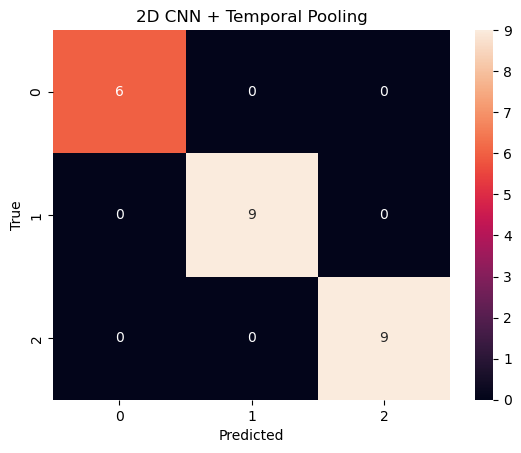

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:01<00:00, 112MB/s] 



🚀 Training 3D CNN (R(2+1)D)


/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5] - Loss: 0.6017
Epoch [2/5] - Loss: 0.1070
Epoch [3/5] - Loss: 0.0902
Epoch [4/5] - Loss: 0.0249
Epoch [5/5] - Loss: 1.3413

📊 3D CNN (R(2+1)D) Performance
Accuracy            : 0.9583
Precision           : 0.9667
Recall              : 0.9630
F1                  : 0.9628
Train Time          : 64.3795
Inf Time            : 0.0219


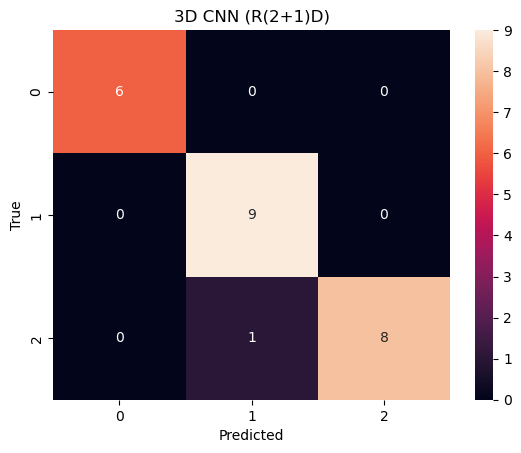

In [28]:
# ==========================================================
# RUN EXPERIMENTS
# ==========================================================
metrics_2d = train_and_evaluate(
    CNN2DTemporal(NUM_CLASSES),
    "2D CNN + Temporal Pooling"
)

metrics_3d = train_and_evaluate(
    CNN3D(NUM_CLASSES),
    "3D CNN (R(2+1)D)"
)

In [15]:
# ==========================================================
# DETAILED COMPARISON REPORT
# ==========================================================

def compare_models(metrics_2d, metrics_3d):
    """
    Generate comparison charts and a detailed report
    for 2D CNN vs 3D CNN models.

    Args:
        metrics_2d (dict): Metrics for 2D CNN
        metrics_3d (dict): Metrics for 3D CNN
    """

    # ------------------------------------------------------
    # Sanity checks
    # ------------------------------------------------------
    required_keys = {"accuracy", "train_time", "inf_time"}

    if not required_keys.issubset(metrics_2d):
        raise ValueError("metrics_2d missing required keys")

    if not required_keys.issubset(metrics_3d):
        raise ValueError("metrics_3d missing required keys")

    # ------------------------------------------------------
    # Extract metrics
    # ------------------------------------------------------
    models = ["2D CNN", "3D CNN"]

    accuracy = [
        metrics_2d["accuracy"],
        metrics_3d["accuracy"]
    ]

    train_time = [
        metrics_2d["train_time"],
        metrics_3d["train_time"]
    ]

    inf_time = [
        metrics_2d["inf_time"],
        metrics_3d["inf_time"]
    ]

    # ======================================================
    # CHART 1: Accuracy Comparison
    # ======================================================
    plt.figure()
    plt.bar(models, accuracy)
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.show()

    # ======================================================
    # CHART 2: Training Time Comparison
    # ======================================================
    plt.figure()
    plt.bar(models, train_time)
    plt.title("Training Time Comparison")
    plt.xlabel("Model")
    plt.ylabel("Time (seconds)")
    plt.show()

    # ======================================================
    # CHART 3: Inference Time Comparison
    # ======================================================
    plt.figure()
    plt.bar(models, inf_time)
    plt.title("Inference Time per Video Comparison")
    plt.xlabel("Model")
    plt.ylabel("Time (seconds)")
    plt.show()

    # ======================================================
    # TEXTUAL COMPARISON REPORT
    # ======================================================
    print("\n" + "=" * 60)
    print("📈 DETAILED MODEL COMPARISON REPORT")
    print("=" * 60)

    # Accuracy
    print("\n🔹 Accuracy Comparison")
    print(f"2D CNN Accuracy : {metrics_2d['accuracy']:.4f}")
    print(f"3D CNN Accuracy : {metrics_3d['accuracy']:.4f}")

    # Efficiency
    print("\n🔹 Computational Efficiency")
    print(f"2D CNN Training Time (s)        : {metrics_2d['train_time']:.2f}")
    print(f"3D CNN Training Time (s)        : {metrics_3d['train_time']:.2f}")
    print(f"2D CNN Inference Time / Video(s): {metrics_2d['inf_time']:.4f}")
    print(f"3D CNN Inference Time / Video(s): {metrics_3d['inf_time']:.4f}")

    # Qualitative analysis
    print("\n🔹 Qualitative Analysis")
    if metrics_3d["accuracy"] > metrics_2d["accuracy"]:
        print(
            "✔ The 3D CNN outperforms the 2D CNN by explicitly modeling "
            "spatiotemporal patterns, making it more suitable for complex actions."
        )
    else:
        print(
            "✔ The 2D CNN achieves competitive accuracy with significantly lower "
            "computational cost, making it suitable for real-time applications."
        )

    # Final conclusion
    print(
        "\n🔹 Final Conclusion:\n"
        "2D CNNs provide a strong baseline with efficient inference, while "
        "3D CNNs offer improved performance at the cost of higher computation."
    )

    print("\n✅ Experiment completed successfully")


print("\n" + "="*60)
print("📈 DETAILED MODEL COMPARISON REPORT")
print("="*60)

print("\n🔹 Accuracy Comparison")
print(f"2D CNN Accuracy : {metrics_2d['accuracy']:.4f}")
print(f"3D CNN Accuracy : {metrics_3d['accuracy']:.4f}")

print("\n🔹 Computational Efficiency")
print(f"2D CNN Training Time (s): {metrics_2d['train_time']:.2f}")
print(f"3D CNN Training Time (s): {metrics_3d['train_time']:.2f}")
print(f"2D CNN Inference Time / Video (s): {metrics_2d['inf_time']:.4f}")
print(f"3D CNN Inference Time / Video (s): {metrics_3d['inf_time']:.4f}")

print("\n🔹 Qualitative Analysis")
if metrics_3d["accuracy"] > metrics_2d["accuracy"]:
    print(
        "✔ The 3D CNN outperforms the 2D CNN by explicitly modeling "
        "spatiotemporal patterns, making it more suitable for complex actions."
    )
else:
    print(
        "✔ The 2D CNN achieves competitive accuracy with significantly lower "
        "computational cost, making it suitable for real-time applications."
    )

print(
    "\n🔹 Final Conclusion:\n"
    "2D CNNs provide a strong baseline with efficient inference, while "
    "3D CNNs offer improved performance at the cost of higher computation."
)

print("\n✅ Experiment completed successfully")



📈 DETAILED MODEL COMPARISON REPORT

🔹 Accuracy Comparison
2D CNN Accuracy : 1.0000
3D CNN Accuracy : 0.9583

🔹 Computational Efficiency
2D CNN Training Time (s): 15.83
3D CNN Training Time (s): 64.24
2D CNN Inference Time / Video (s): 0.0133
3D CNN Inference Time / Video (s): 0.0192

🔹 Qualitative Analysis
✔ The 2D CNN achieves competitive accuracy with significantly lower computational cost, making it suitable for real-time applications.

🔹 Final Conclusion:
2D CNNs provide a strong baseline with efficient inference, while 3D CNNs offer improved performance at the cost of higher computation.

✅ Experiment completed successfully
